In [8]:
import random
import string
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
def generate_random_files(byte_size: int):
    random_text: str = ''.join(random.choices(string.ascii_letters + string.digits + string.punctuation + ' ', k = byte_size))
    return random_text

def write_to_file(directory: str, filename: str, byte_size: int):
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, filename)
    random_text = generate_random_files(byte_size)

    with open(file_path, 'w') as file:
        file.write(random_text)

### AES

In [10]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from binascii import hexlify
from numpy import array, mean, var, std, sqrt

import timeit, secrets

In [11]:
def aes_encrypt_file(path: str, key: int, new_path: str = None) -> tuple[int, int]:
    # Generate a random IV (16 bytes for AES)
    iv: bytes = secrets.token_bytes(16)

    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()

    # Read the plaintext file in binary mode
    with open(path, "rb") as plaintext_file:
        plaintext = plaintext_file.read()

    # Make sure the plaintext length is a multiple of block size (AES block size is 16 bytes)
    padding_length = 16 - len(plaintext) % 16
    padded_plaintext = plaintext + bytes([padding_length]) * padding_length

    # Encrypt the padded plaintext
    ct: bytes = encryptor.update(padded_plaintext) + encryptor.finalize()

    # Write the ciphertext to a new file
    with open(path if new_path == None else new_path + ".bin", "wb") as cphFile:
        cphFile.write(iv)  # Prepend IV to the ciphertext for decryption later
        cphFile.write(ct)

    # print(f"Encryption successful! File saved as: {new_path or path}")
    return hexlify(key), iv

def aes_decrypt_file(path: str, key: int, new_path: str = None) -> None:
    # Read the ciphertext file
    with open(path, "rb") as cphFile:
        iv: bytes = cphFile.read(16)  # Extract the IV (first 16 bytes)
        ct: bytes = cphFile.read()    # Read the rest as ciphertext

    # Create the cipher
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()

    # Decrypt the ciphertext
    padded_plaintext = decryptor.update(ct) + decryptor.finalize()

    # Remove padding (last byte value determines padding length)
    padding_length = padded_plaintext[-1]
    plaintext = padded_plaintext[:-padding_length]

    # Write the decrypted plaintext to a new file
    with open(path[:-4] if new_path is None else new_path, "wb") as plaintext_file:
        plaintext_file.write(plaintext)

    # print(f"Decryption successful! File saved as: {new_path or path}")

In [ ]:
def test_aes(directory: str, size: int, amount: int = 100, same_file: bool = False) -> tuple[tuple[float, float, float], tuple[float, float, float]]:
    assert amount > 0

    results: list[list[float]] = [[], []]
    filename: str = f"random_text_{size}.bin"

    for i in range(amount):
        key: bytes = os.urandom(32)
        iv: bytes = secrets.token_bytes(16)
        
        if not same_file or i < 1:
            write_to_file(directory, filename, size)

        path: str = os.path.join(directory, filename)
        with open(path, "rb") as plaintext_file:
            plaintext = plaintext_file.read()

        padding_length = 16 - len(plaintext) % 16
        padded_plaintext = plaintext + bytes([padding_length]) * padding_length

        encrypt_trials = array(timeit.repeat(
            lambda: Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().update(padded_plaintext) +
                    Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().finalize(),
            number = 1,
            repeat = 1
        ))

        ct: bytes = Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().update(padded_plaintext) + \
                    Cipher(algorithms.AES(key), modes.CBC(iv)).encryptor().finalize()

        decrypt_trials = array(timeit.repeat(
            lambda: Cipher(algorithms.AES(key), modes.CBC(iv)).decryptor().update(ct) +
                    Cipher(algorithms.AES(key), modes.CBC(iv)).decryptor().finalize(),
            number = 1,
            repeat = 1
        ))

        results[0].extend(encrypt_trials)
        results[1].extend(decrypt_trials)

    mean_encrypt = mean(results[0]) * 1e6
    mean_decrypt = mean(results[1]) * 1e6

    var_encrypt = var(results[0], ddof = 1) * 1e6
    var_decrypt = var(results[1], ddof = 1) * 1e6

    stderr_encrypt = std(results[0], ddof = 1) / sqrt(len(results[0])) * 1e6
    stderr_decrypt = std(results[1], ddof = 1) / sqrt(len(results[1])) * 1e6

    return (
        (mean_encrypt, var_encrypt, stderr_encrypt),
        (mean_decrypt, var_decrypt, stderr_decrypt)
    )

In [13]:
def print_results(test: str, result: tuple[tuple[float, float, float], tuple[float, float, float]]) -> None:
    print(f"Test {test}:")
    print(f"\tencryption:\n\t\tmean: {result[0][0]:.5f}\n\t\tstd error: {result[0][1]:.5e}\n\t\tvariance: {result[0][2]:.5e}")
    print(f"\tdecryption:\n\t\tmean: {result[1][0]:.5f}\n\t\tstd error: {result[1][1]:.5e}\n\t\tvariance: {result[1][2]:.5e}")

def plot_all_results(tests: list[str], sizes: list[int], results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    x = np.arange(len(tests))
    
    means_encrypt = [result[0][0] for result in results]
    means_decrypt = [result[1][0] for result in results]
    std_errors_encrypt = [result[0][1] for result in results]
    std_errors_decrypt = [result[1][1] for result in results]
    
    # First plot (Standard test names on x-axis)
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(x, means_encrypt, '-o', color='blue', label="Encryption")
    ax.fill_between(x, np.array(means_encrypt) - np.array(std_errors_encrypt), 
                     np.array(means_encrypt) + np.array(std_errors_encrypt), color='blue', alpha=0.2)
    
    ax.plot(x, means_decrypt, '-s', color='green', label="Decryption")
    ax.fill_between(x, np.array(means_decrypt) - np.array(std_errors_decrypt), 
                     np.array(means_decrypt) + np.array(std_errors_decrypt), color='green', alpha=0.2)
    
    ax.set_ylabel("Time (Microseconds)")
    ax.set_title("AES Performance for Different Tests")
    ax.set_xticks(x)
    ax.set_xticklabels(tests, rotation=45, ha="right")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Second plot (Actual input sizes in bytes on x-axis)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(sizes, means_encrypt, '-o', color='blue', label="Encryption")
    ax.fill_between(sizes, np.array(means_encrypt) - np.array(std_errors_encrypt), 
                     np.array(means_encrypt) + np.array(std_errors_encrypt), color='blue', alpha=0.2)
    
    ax.plot(sizes, means_decrypt, '-s', color='green', label="Decryption")
    ax.fill_between(sizes, np.array(means_decrypt) - np.array(std_errors_decrypt), 
                     np.array(means_decrypt) + np.array(std_errors_decrypt), color='green', alpha=0.2)
    
    ax.set_xscale("log", base = 10)
    ax.set_yscale("log", base = 10)
    ax.set_xlabel("Input Size (Bytes)")
    ax.set_ylabel("Time (µs)")
    ax.set_title("AES Performance vs Input Size")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def print_confidence_interval(mean: float, std_dev: float, label: str) -> None:
    confidence_interval = stats.norm.interval(0.99, loc=mean, scale=std_dev)
    print(f"{label} 95% Confidence Interval: ({confidence_interval[0]:.3f}, {confidence_interval[1]:.3f}) µs")

def print_all_confidence_intervals(results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    for i, result in enumerate(results):
        print_confidence_interval(result[0][0], result[0][1], f"Encryption Test {i+1}")
        print_confidence_interval(result[1][0], result[1][1], f"Decryption Test {i+1}")
        
def print_avg_error(mean: float, std_dev: float, label: str) -> None:
    error = stats.norm.ppf(0.95) * std_dev  # 95% confidence z-score ≈ 2.576
    print(f"{label}: {mean:.3e} ± {error:.3e} µs")

def print_all_avg_errors(results: list[tuple[tuple[float, float, float], tuple[float, float, float]]]) -> None:
    for i, result in enumerate(results):
        print_avg_error(result[0][0], result[0][1], f"Encryption Test {i+1}")
        print_avg_error(result[1][0], result[1][1], f"Decryption Test {i+1}")

In [14]:
sizes: list[int] = [8, 64, 512, 4096, 32768, 262144, 2097152]
directory: str = "random_files"


Same File for Different Sizes


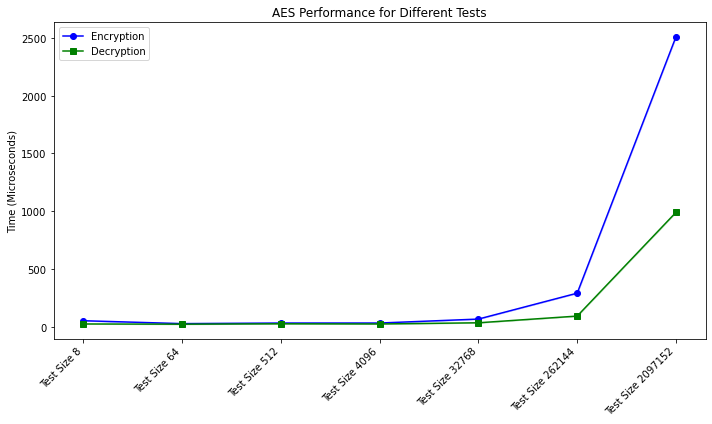

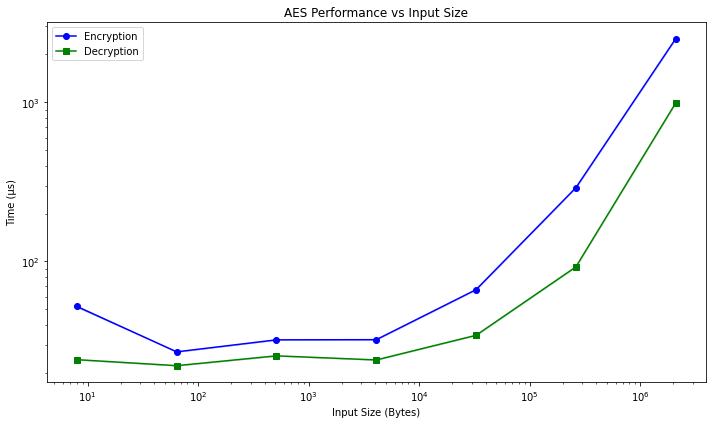

In [15]:
results = []
amount: int = 1000

print("\nSame File for Different Sizes")
for i in range(len(sizes)):
    result = test_aes(directory, sizes[i], amount, True)
    results.append(result)
plot_all_results([f"Test Size {size}" for size in sizes], sizes, results)

aes_results = results


Random Files for Different Sizes


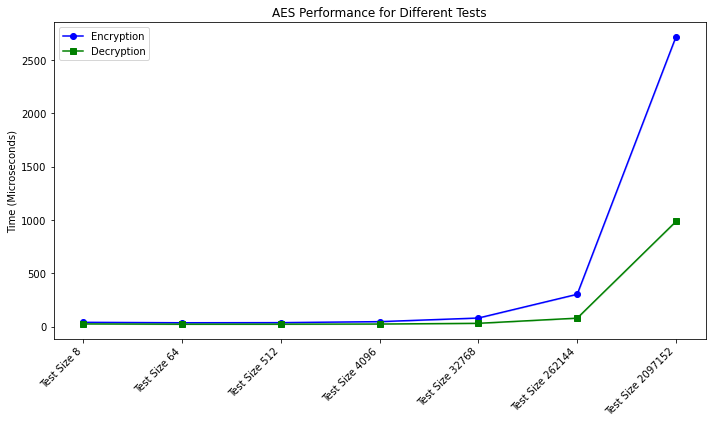

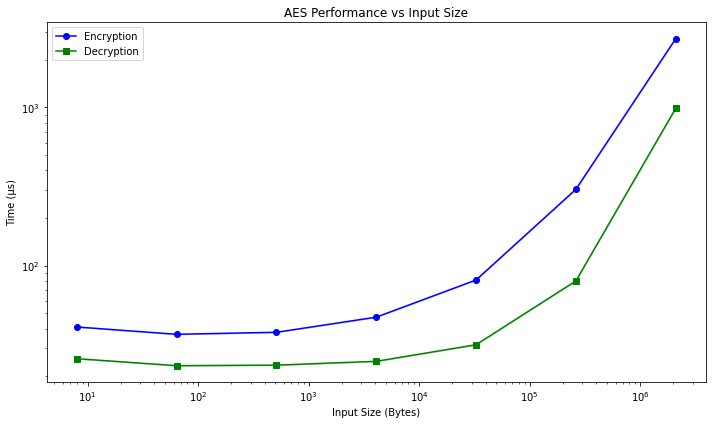

In [16]:
results = []

print("\nRandom Files for Different Sizes")
for i in range(len(sizes)):
    result = test_aes(directory, sizes[i], amount)
    results.append(result)
plot_all_results([f"Test Size {size}" for size in sizes], sizes, results)

In [17]:
print_all_confidence_intervals(results)
print_all_avg_errors(results)

Encryption Test 1 95% Confidence Interval: (40.987, 40.989) µs
Decryption Test 1 95% Confidence Interval: (25.841, 25.842) µs
Encryption Test 2 95% Confidence Interval: (36.853, 36.853) µs
Decryption Test 2 95% Confidence Interval: (23.348, 23.348) µs
Encryption Test 3 95% Confidence Interval: (37.958, 37.959) µs
Decryption Test 3 95% Confidence Interval: (23.530, 23.530) µs
Encryption Test 4 95% Confidence Interval: (47.302, 47.302) µs
Decryption Test 4 95% Confidence Interval: (24.875, 24.875) µs
Encryption Test 5 95% Confidence Interval: (81.241, 81.242) µs
Decryption Test 5 95% Confidence Interval: (31.661, 31.661) µs
Encryption Test 6 95% Confidence Interval: (303.863, 303.868) µs
Decryption Test 6 95% Confidence Interval: (80.109, 80.109) µs
Encryption Test 7 95% Confidence Interval: (2717.698, 2717.729) µs
Decryption Test 7 95% Confidence Interval: (986.323, 986.621) µs
Encryption Test 1: 4.099e+01 ± 3.811e-04 µs
Decryption Test 1: 2.584e+01 ± 1.691e-04 µs
Encryption Test 2: 3.6

### SHA-256

In [18]:
from cryptography.hazmat.primitives import hashes
from timeit import default_timer as timer

In [19]:
def compute_sha256(file_path: str) -> tuple[float, bytes]:
    digest = hashes.Hash(hashes.SHA256())

    with open(file_path, 'rb') as file:
        data = file.read()

    start = timer()
    digest.update(data)
    hashing = digest.finalize()
    end = timer()

    elapsed_time_us = (end - start) * 1000000  
    return elapsed_time_us, hashing

def file_time(filename: str) -> float:
    time, _ = compute_sha256(filename)
    return time

def print_results(test: str, result: tuple[float, float, float]) -> None:
    print(f"Test {test}:")
    print(f"\t\tmean: {result[0][0]:.5f}\n\tvariance: {result[0][1]:.5e}\n\std error: {result[0][2]:.5e}")

In [20]:
def test_sha256(directory: str, size: int, amount: int = 100, same_file: bool = False) -> tuple[float, float, float]:
    assert amount > 0

    results = []
    filename: str = f"random_text_{size}.bin"
    
    for i in range(amount):
        if not same_file or i < 1:
            write_to_file(directory, filename, size)
        path: str = os.path.join(directory, filename)
        results.append(file_time(path))

    return (mean(results), var(results, ddof = 1), std(results, ddof = 1) / sqrt(amount))

In [21]:
def compare_variation(sizes: list[int], results1: list[tuple[float, float, float]], results2: list[tuple[float, float, float]], labels: list[str]) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, [mean for mean, _, _ in results1], marker='o', linestyle='-', color='b', label=labels[0])
    plt.plot(sizes, [mean for mean, _, _ in results2], marker='s', linestyle='--', color='r', label=labels[1])

    plt.xlabel("Input Size (Bytes)")
    plt.ylabel("Time (µs)")
    plt.title("SHA Digest Generation: Same vs Different Files")
    plt.xscale("log", base = 10) 
    plt.yscale("log", base = 10)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

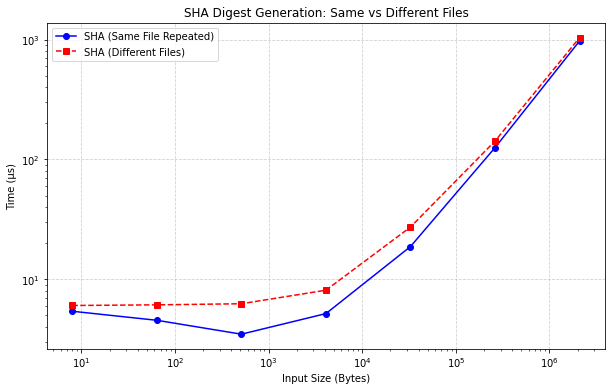

SHA-256 - File Size 8 95% Confidence Interval: (-12.733, 24.829) µs
SHA-256 - File Size 8: 6.048e+00 ± 1.199e+01 µs
SHA-256 - File Size 64 95% Confidence Interval: (-13.887, 26.135) µs
SHA-256 - File Size 64: 6.124e+00 ± 1.278e+01 µs
SHA-256 - File Size 512 95% Confidence Interval: (-5.045, 17.556) µs
SHA-256 - File Size 512: 6.255e+00 ± 7.216e+00 µs
SHA-256 - File Size 4096 95% Confidence Interval: (-7.888, 24.117) µs
SHA-256 - File Size 4096: 8.114e+00 ± 1.022e+01 µs
SHA-256 - File Size 32768 95% Confidence Interval: (-184.560, 239.136) µs
SHA-256 - File Size 32768: 2.729e+01 ± 1.353e+02 µs
SHA-256 - File Size 262144 95% Confidence Interval: (-145.749, 430.823) µs
SHA-256 - File Size 262144: 1.425e+02 ± 1.841e+02 µs
SHA-256 - File Size 2097152 95% Confidence Interval: (-57035.698, 59111.604) µs
SHA-256 - File Size 2097152: 1.038e+03 ± 3.708e+04 µs


In [22]:
sha_times_same: list[tuple[float, float, float]] = [test_sha256(directory, size, amount, same_file = True) for size in sizes]
sha_times_different: list[tuple[float, float, float]] = [test_sha256(directory, size, amount) for size in sizes]

compare_variation(sizes, sha_times_same, sha_times_different, ["SHA (Same File Repeated)", "SHA (Different Files)"])

for i, size in enumerate(sizes):
    print_confidence_interval(sha_times_different[i][0], sha_times_different[i][1], f"SHA-256 - File Size {size}")
    print_avg_error(sha_times_different[i][0], sha_times_different[i][1], f"SHA-256 - File Size {size}")

### RSA

In [23]:
from cryptography.hazmat.primitives.asymmetric import rsa, padding 
from collections import defaultdict


Public and Private Key generation

In [24]:
private_key = rsa.generate_private_key(
    public_exponent = 65537,
    key_size = 2048
)

public_key = private_key.public_key()

In [25]:
rsa_directory = 'random_rsa_files'

def generate_rsa_files():
    RSA_sizes = [2, 4, 8, 16, 32, 64, 128]
    for size in RSA_sizes:
        filename = f'random_text_{size}.txt'
        write_to_file(rsa_directory, filename, size)

Encryption

In [26]:
def rsa_encryption(plaintext, public_key):
    start = timer()
    ciphertext = public_key.encrypt(
        plaintext,
        padding.OAEP(
            mgf = padding.MGF1(algorithm = hashes.SHA256()),
            algorithm = hashes.SHA256(),
            label = None
        )
    )
    end = timer()

    encryption_time: float = (end - start) * 1000000 # microseconds
    return encryption_time, ciphertext

Decryption

In [27]:
def rsa_decryption(ciphertext, private_key):
    start = timer()
    _ = private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf = padding.MGF1(algorithm = hashes.SHA256()),
            algorithm = hashes.SHA256(),
            label = None
        )
    )
    end = timer()
    decryption_time: float = (end-start) * 1000000 # microseconds 
    
    return decryption_time

Plaintext reading from files

In [28]:
def rsa_encrypt_decrypt(plaintext):
    encrypt_time, ciphertext = rsa_encryption(plaintext, public_key)
    decrypt_time = rsa_decryption(ciphertext, private_key)
    return encrypt_time, decrypt_time

In [29]:
def plot_rsa_performance(file_info):
    file_sizes = sorted(file_info.keys())

    mean_encrypt = [file_info[size][0] for size in file_sizes]
    mean_decrypt = [file_info[size][1] for size in file_sizes]

    var_encrypt = [file_info[size][2] for size in file_sizes]
    var_decrypt = [file_info[size][3] for size in file_sizes]

    stderr_encrypt = [file_info[size][4] for size in file_sizes]
    stderr_decrypt = [file_info[size][5] for size in file_sizes]


    x_positions = range(len(file_sizes))  # Evenly spaced x positions

    plt.figure(figsize = (10, 6))
    
    # Média com barras de erro    
    scale_factor = 7
    plt.errorbar(x_positions, mean_encrypt, yerr = np.array(stderr_encrypt) * scale_factor, fmt='o-', capsize=5, label="Encryption Time (Avg ± StdErr)", color="blue")
    plt.errorbar(x_positions, mean_decrypt, yerr = np.array(stderr_decrypt) * scale_factor, fmt='s-', capsize=5, label="Decryption Time (Avg ± StdErr)", color="red")

    # Variância como área sombreada
    plt.fill_between(x_positions, np.array(mean_encrypt) - np.sqrt(var_encrypt), np.array(mean_encrypt) + np.sqrt(var_encrypt), color="blue", alpha=0.2)
    plt.fill_between(x_positions, np.array(mean_decrypt) - np.sqrt(var_decrypt), np.array(mean_decrypt) + np.sqrt(var_decrypt), color="red", alpha=0.2)


    plt.xticks(x_positions, file_sizes, rotation=45, ha="right")  # Rotate labels for readability
    plt.xlabel("Input Size (Bytes)")
    plt.ylabel("Time (µs)")
    plt.title("RSA Encryption & Decryption Time by File")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [30]:
def process_file_info(file_info):
    final_file_info = {}

    for file_size, times in file_info.items():
        encrypt_times = np.array(times["encrypt_times"])
        decrypt_times = np.array(times["decrypt_times"])

        mean_encrypt = np.mean(encrypt_times)
        mean_decrypt = np.mean(decrypt_times)

        var_encrypt = np.var(encrypt_times, ddof=1)  # ddof=1 para variância amostral
        var_decrypt = np.var(decrypt_times, ddof=1)

        stderr_encrypt = np.sqrt(var_encrypt / len(encrypt_times))  # Erro padrão
        stderr_decrypt = np.sqrt(var_decrypt / len(decrypt_times))

        final_file_info[file_size] = [mean_encrypt, mean_decrypt, var_encrypt, var_decrypt, stderr_encrypt, stderr_decrypt]

    return final_file_info

In [31]:
def get_same_file_info():
    file_info = defaultdict(lambda: {"encrypt_times": [], "decrypt_times": []})
    generate_rsa_files()
    
    for filename in os.listdir(rsa_directory):
        filepath = os.path.join(rsa_directory, filename)
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding = "utf-8") as file:
                plaintext = file.read().encode()

            file_size = os.path.getsize(filepath)

            for _ in range(1000):
                e_time, d_time = rsa_encrypt_decrypt(plaintext)

                file_info[file_size]["encrypt_times"].append(e_time)
                file_info[file_size]["decrypt_times"].append(d_time)

    return file_info

In [32]:
def get_rand_file_info():
    file_info = defaultdict(lambda: {"encrypt_times": [], "decrypt_times": []})

    for i in range(1000):
        generate_rsa_files()

        for filename in os.listdir(rsa_directory):
            filepath = os.path.join(rsa_directory, filename)
            
            if os.path.isfile(filepath):
                with open(filepath, "r", encoding = "utf-8") as file:
                    plaintext = file.read().encode()

                file_size = os.path.getsize(filepath)

                e_time, d_time = rsa_encrypt_decrypt(plaintext)
                file_info[file_size]["encrypt_times"].append(e_time)
                file_info[file_size]["decrypt_times"].append(d_time)

    return file_info

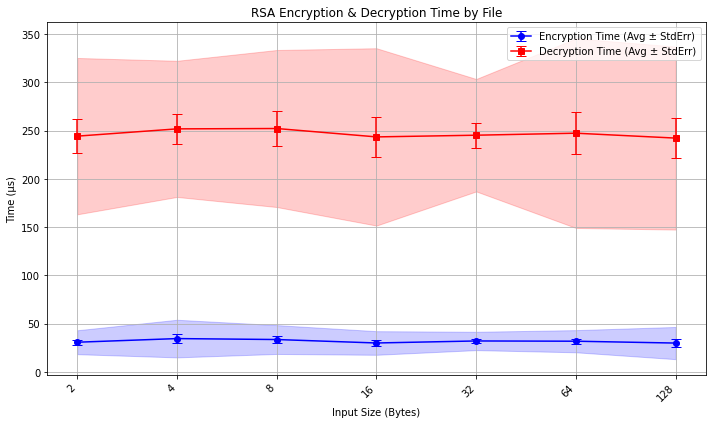

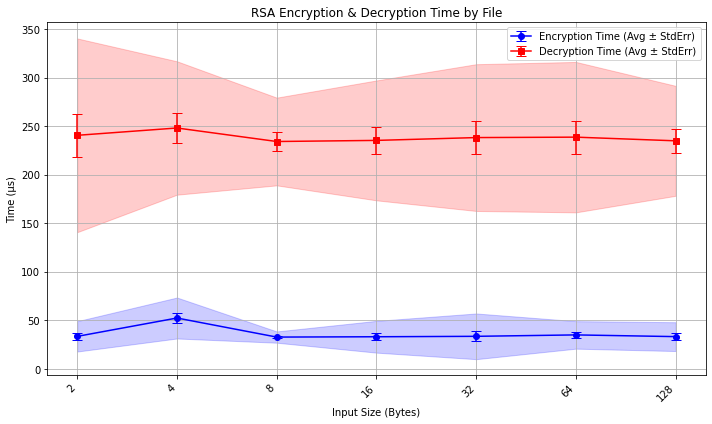

In [33]:
file_info = get_same_file_info()
final_file_info = process_file_info(file_info)
plot_rsa_performance(final_file_info)

file_info = get_rand_file_info()
final_file_info = process_file_info(file_info)
plot_rsa_performance(final_file_info)

In [34]:
results = [
            ((test[0], test[2], test[4]), (test[1], test[3], test[5]))
            for test in sorted(final_file_info.values())
        ]
print_all_confidence_intervals(results)
print_all_avg_errors(results)

Encryption Test 1 95% Confidence Interval: (-54.246, 119.497) µs
Decryption Test 1 95% Confidence Interval: (-5028.667, 5496.918) µs
Encryption Test 2 95% Confidence Interval: (-657.241, 723.160) µs
Decryption Test 2 95% Confidence Interval: (-9590.872, 10061.396) µs
Encryption Test 3 95% Confidence Interval: (-535.099, 601.283) µs
Decryption Test 3 95% Confidence Interval: (-8029.494, 8499.153) µs
Encryption Test 4 95% Confidence Interval: (-596.410, 663.122) µs
Decryption Test 4 95% Confidence Interval: (-25421.549, 25902.559) µs
Encryption Test 5 95% Confidence Interval: (-1394.215, 1461.029) µs
Decryption Test 5 95% Confidence Interval: (-14486.646, 14962.998) µs
Encryption Test 6 95% Confidence Interval: (-482.566, 552.301) µs
Decryption Test 6 95% Confidence Interval: (-15228.457, 15705.685) µs
Encryption Test 7 95% Confidence Interval: (-1093.857, 1198.397) µs
Decryption Test 7 95% Confidence Interval: (-11917.264, 12413.360) µs
Encryption Test 1: 3.263e+01 ± 5.547e+01 µs
Decryp

In [35]:
def plot_crypto_results_aes_rsa(
    sizes_a: list[int],
    results_a: list[tuple[tuple[float, float, float], tuple[float, float, float]]],
    sizes_b: list[int],
    results_b: list[tuple[tuple[float, float, float], tuple[float, float, float]]]
) -> None:
    """
    Plots the encryption and decryption results for two cryptographic algorithms (e.g., AES and RSA)
    as (size, result) graphs, only up to the minimum of the max input sizes.
    
    sizes_a and sizes_b: list of input sizes in bytes
    results_a and results_b: list of tuples:
        ((enc_mean, enc_var, enc_stderr), (dec_mean, dec_var, dec_stderr))
    """
    # Determine cutoff limit
    max_size = min(max(sizes_a), max(sizes_b))

    # Filter AES data
    aes_filtered = [(s, r) for s, r in zip(sizes_a, results_a) if s <= max_size]
    aes_sizes = [s for s, _ in aes_filtered]
    aes_enc_means = [r[0][0] for _, r in aes_filtered]
    aes_enc_stderr = [r[0][2] for _, r in aes_filtered]
    aes_dec_means = [r[1][0] for _, r in aes_filtered]
    aes_dec_stderr = [r[1][2] for _, r in aes_filtered]

    # Filter RSA data
    rsa_filtered = [(s, r) for s, r in zip(sizes_b, results_b) if s <= max_size]
    rsa_sizes = [s for s, _ in rsa_filtered]
    rsa_enc_means = [r[0][0] for _, r in rsa_filtered]
    rsa_enc_stderr = [r[0][2] for _, r in rsa_filtered]
    rsa_dec_means = [r[1][0] for _, r in rsa_filtered]
    rsa_dec_stderr = [r[1][2] for _, r in rsa_filtered]


    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot AES
    ax.errorbar(aes_sizes, aes_enc_means, yerr=aes_enc_stderr, label="AES Encryption", fmt='-o', capsize=4)
    ax.errorbar(aes_sizes, aes_dec_means, yerr=aes_dec_stderr, label="AES Decryption", fmt='-o', capsize=4)

    # Plot RSA
    ax.errorbar(rsa_sizes, rsa_enc_means, yerr=rsa_enc_stderr, label="RSA Encryption", fmt='-s', capsize=4)
    ax.errorbar(rsa_sizes, rsa_dec_means, yerr=rsa_dec_stderr, label="RSA Decryption", fmt='-s', capsize=4)

    ax.set_xlabel("Input Size (Bytes)")
    ax.set_ylabel("Time (µs)")
    ax.set_title("Encryption and Decryption Time vs Input Size (Truncated to Shared Max)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [36]:
def plot_crypto_results_aes_sha(
    sizes_a: list[int],
    results_a: list[tuple[tuple[float, float, float], tuple[float, float, float]]],
    sizes_b: list[int],
    results_b: list[tuple[tuple[float, float, float], tuple[float, float, float]]]
) -> None:
    # Determine cutoff limit
    max_size = min(max(sizes_a), max(sizes_b))

    # Filter AES data
    aes_filtered = [(s, r) for s, r in zip(sizes_a, results_a) if s <= max_size]
    aes_sizes = [s for s, _ in aes_filtered]
    aes_enc_means = [r[0][0] for _, r in aes_filtered]
    aes_enc_stderr = [r[0][2] for _, r in aes_filtered]
    aes_dec_means = [r[1][0] for _, r in aes_filtered]
    aes_dec_stderr = [r[1][2] for _, r in aes_filtered]

    # Filter SHA-256 data
    sha256_filtered = [(s, r) for s, r in zip(sizes_b, results_b) if s <= max_size]
    sha256_sizes = [s for s, _ in sha256_filtered]
    sha256_means = [r[0] for _, r in sha256_filtered]
    sha256_stderr = [r[2] for _, r in sha256_filtered]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot AES
    ax.errorbar(aes_sizes, aes_enc_means, yerr=aes_enc_stderr, label="AES Encryption", fmt='-o', capsize=4)
    ax.errorbar(aes_sizes, aes_dec_means, yerr=aes_dec_stderr, label="AES Decryption", fmt='-o', capsize=4)

    # Plot RSA
    ax.errorbar(sha256_sizes, sha256_means, yerr=sha256_stderr, label="SHA-256 Digest", fmt='-s', capsize=4)

    ax.set_xlabel("Input Size (Bytes)")
    ax.set_ylabel("Time (µs)")
    ax.set_title("Encryption/Decryption/Digest Time vs Input Size")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


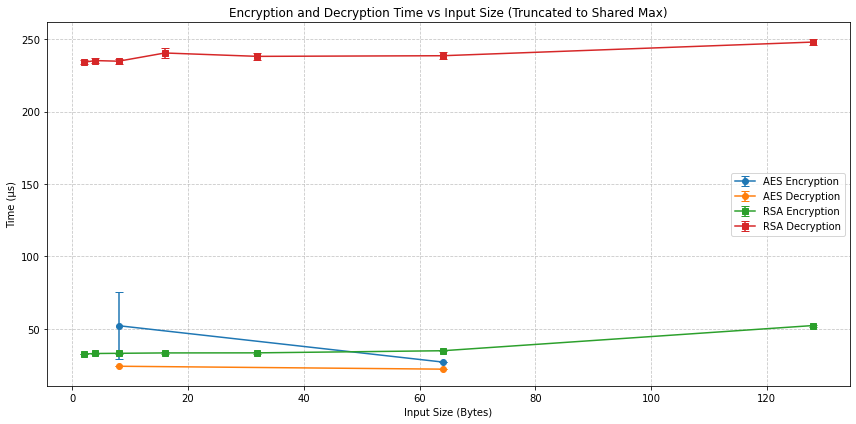

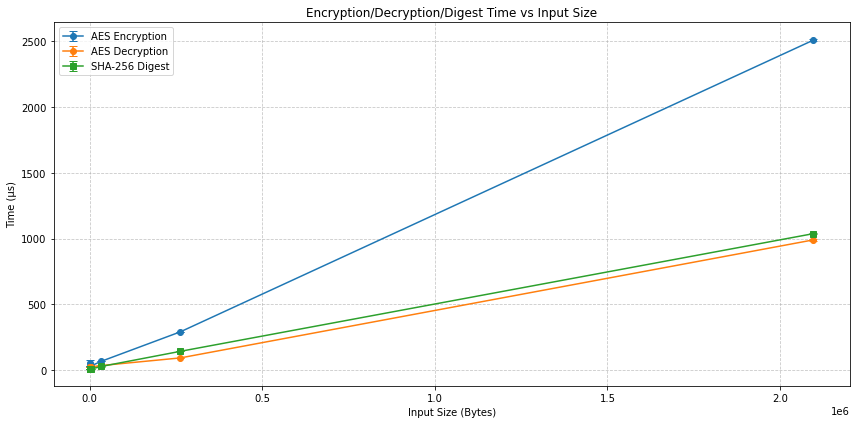

In [37]:
aes_sizes: list[int] = [8, 64, 512, 4096, 32768, 262144, 2097152]
rsa_sizes: list[int] = [2, 4, 8, 16, 32, 64, 128]
plot_crypto_results_aes_rsa(aes_sizes, aes_results, rsa_sizes, results)
plot_crypto_results_aes_sha(aes_sizes, aes_results, aes_sizes, sha_times_different)

Delete the generated files

In [38]:
for i in range(len(sizes)):
    filepath: str = os.path.join(directory, f"random_text_{sizes[i]}.bin")
    if os.path.isfile(filepath):
        os.remove(filepath)

In [39]:
for filename in os.listdir(rsa_directory):
    filepath: str = os.path.join(rsa_directory, filename)
    if os.path.isfile(filepath):
        os.remove(filepath)